In [ ]:
# Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np
from scipy.stats import binomtest, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
from datetime import datetime
import re
import ast
import hashlib
import warnings

warnings.filterwarnings("ignore")

#### Ранее в задании по проекту мы написали код для экспериментирования с моделями в нашем сервисе. Этот код вместе с рекомендациями возвращает группу, в которую попал пользователь.

#### Представим, что мы проводили этот эксперимент на пользователях в течение 2 недель. В результаты мы получили сырые данные об эксперименте, которые нам надо обработать и сделать выводы.

#### В результате у нас получилось 2 таблички:

- **Ответы наши сервиса с рекомендациями** — в них мы знаем, какому пользователю что мы порекомендовали и в какую группу его отнесли. И, конечно, знаем момент времени, когда это произошло.

- **Данные о лайках** — в них мы знаем, какой пользователь и какой пост лайкнул, в том числе момент времени, когда это произошло.


In [2]:
views = pd.read_csv("views.csv")
likes = pd.read_csv("likes.csv")

In [3]:
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [4]:
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [5]:
# Посмотрим на размеры табличек

views.shape, likes.shape

((193295, 4), (230176, 3))

#### Начнём с проверки разбиения групп.

Во-первых, у нас нет таблички соответствия пользователь-группа, так как мы на самом деле определяли группу пользователя прямо перед подготовкой рекомендаций.

В реальности бывают лаги системы (например, если мы запрашиваем группу пользователя, то не всегда можем получить ответ) и это свойство не выполняется. Проверим, нет ли у нас пользователей, которые попали в обе группы. Если их совсем немного, удалим их из обеих выборок (если бы было много, то надо было разбираться, что пошло не так).


In [ ]:
check_users = (
    views.groupby(by="user_id").aggregate({"exp_group": "nunique"}).reset_index()
)
double_users = check_users[check_users["exp_group"] > 1]["user_id"]

double_users

10071     25623
20633     55788
54475    142283
57065    148670
Name: user_id, dtype: int64

У нас всего 4 пользователя с задублированной группой, поэтому просто удалим их.


In [7]:
new_views = views[~views["user_id"].isin(double_users)]
new_likes = likes[~likes["user_id"].isin(double_users)]

Теперь, когда мы знаем про однозначное соответствие, сделаем табличку пользователь-группа. Проверим, что группы получаются одинакового размера по пользователям. Для этого можно посчитать долю каждой группы, а ещё можно применить критерий для долей (биномиальный тест), чтобы проверить соответствие этой доли ожидаемым 0.5.


In [8]:
user_group_df = (
    new_views[["user_id", "exp_group"]]
    .sort_values(by=["user_id"], ascending=True)
    .drop_duplicates(subset=["user_id", "exp_group"])
    .reset_index(drop=True)
)
user_group_df.head()

,user_id,exp_group
0,200,test
1,201,test
2,202,test
3,212,test
4,213,test


In [10]:
group_counts = user_group_df["exp_group"].value_counts()
group_props = group_counts / len(user_group_df)

print("Распределение пользователей:")
print(f"Группа A: {group_counts['control']} ({group_props['control']:.2%})")
print(f"Группа B: {group_counts['test']} ({group_props['test']:.2%})")

Распределение пользователей:
Группа A: 32350 (49.76%)
Группа B: 32659 (50.24%)


Как и ожидалось, получили разбивку по группам 50/50.


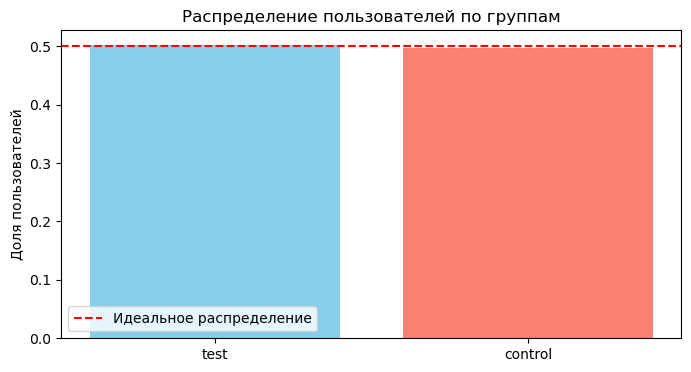


Биномиальный тест:
p-value = 0.2271
Не отвергаем H0: распределение равномерное (p ≥ 0.05)

Соотношение размеров групп: 1.010


In [12]:
# Визуализация
plt.figure(figsize=(8, 4))
plt.bar(group_props.index, group_props.values, color=["skyblue", "salmon"])
plt.axhline(0.5, color="red", linestyle="--", label="Идеальное распределение")
plt.ylabel("Доля пользователей")
plt.title("Распределение пользователей по группам")
plt.legend()
plt.show()

# Биномиальный тест
# H0: p = 0.5 (распределение равномерное)
# H1: p ≠ 0.5 (распределение неравномерное)

test_result = binomtest(
    k=min(group_counts),  # Меньшая группа
    n=len(user_group_df),  # Общее число пользователей
    p=0.5,  # Ожидаемая доля
    alternative="two-sided",
)

print("\nБиномиальный тест:")
print(f"p-value = {test_result.pvalue:.4f}")
if test_result.pvalue < 0.05:
    print("Отвергаем H0: распределение НЕ равномерное (p < 0.05)")
else:
    print("Не отвергаем H0: распределение равномерное (p ≥ 0.05)")

# Проверка баланса (дополнительно)
balance_ratio = max(group_props) / min(group_props)
print(f"\nСоотношение размеров групп: {balance_ratio:.3f}")

In [13]:
assert user_group_df["user_id"].nunique() == len(
    user_group_df
), "Есть дубликаты user_id"

Теперь давайте попробуем оценить, а улучшаются ли наши метрики в тестовой группе.

Соберем табличку, в которой будут пользователи, попавшие в наш эксперимент (то есть те, для которых мы строили хотя бы одну рекомендацию). Посчитайте, кто из них сколько лайков сделал. Наверняка будут пользователи, которые не сделали ни один лайк.

Посчитаем долю пользователей, которая сделала хотя бы один лайк за время эксперимента без разбивки на группы.


In [14]:
user_stats = (
    new_likes[new_likes["user_id"].isin(user_group_df["user_id"])]
    .groupby(by=["user_id"])
    .aggregate({"post_id": "count"})
    .reset_index()
)

total = user_group_df["user_id"].nunique()
more_than_one = user_stats[user_stats["post_id"] >= 1]["user_id"].nunique()

result = round(more_than_one / total * 100, 2)

print(result)

89.48


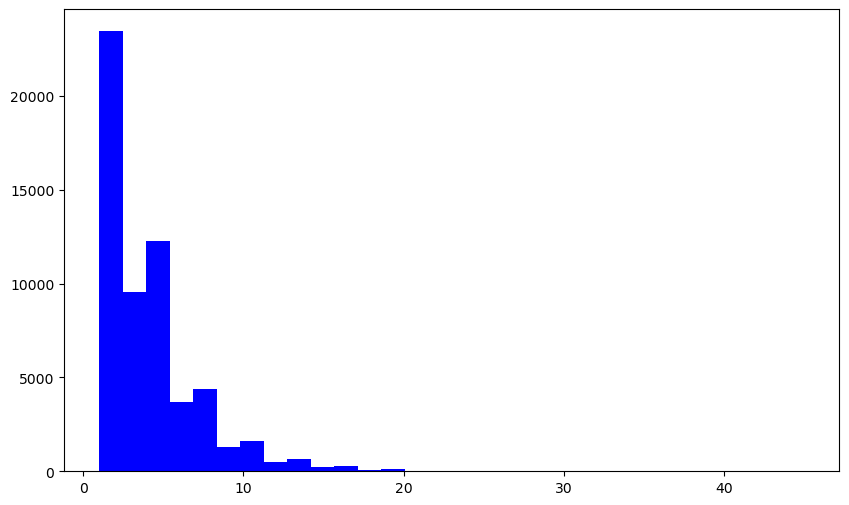

In [ ]:
fig = plt.figure()
fig.set_size_inches(w=10, h=6)

plt.hist(x=user_stats["post_id"], bins=30, color="blue")
plt.show()

### Как и ожидалось, кол-во лайков имеет логнормальное распределение.

А теперь давайте оценим, различаются ли число лайков между группами. Выберем подходящий статистический критерий и проверьте две метрики: доля пользователей с хотя бы одним лайком, число лайков на пользователя.

Доля пользователей с хотя бы одним лайком проверим с помощью z-теста для пропорций, а число лайков на пользователя с помощью критерий Манна-Уитни-Уилкоксона


In [21]:
df_merged = (
    pd.merge(left=user_group_df, right=user_stats, how="left", on="user_id")
    .rename(columns={"post_id": "likes"})
    .fillna(value=0)
)

df_merged["likes"] = df_merged["likes"].astype("int")

df_merged.head()

,user_id,exp_group,likes
0,200,test,1
1,201,test,3
2,202,test,2
3,212,test,4
4,213,test,7


Эти две метрики по смыслу довольно похожи и, скорее всего, коррелируют. Так что давайте по ним ответим на вопрос "стали люди ставить больше лайков в тестовой группе". Используем уровень значимости 0.05.


In [22]:
n_control = len(df_merged[df_merged["exp_group"] == "control"])
n_test = len(df_merged[df_merged["exp_group"] == "test"])

k_control = len(
    df_merged[(df_merged["exp_group"] == "control") & (df_merged["likes"] >= 1)]
)
k_test = len(df_merged[(df_merged["exp_group"] == "test") & (df_merged["likes"] >= 1)])

# Z-тест
z_stat, p_value = proportions_ztest(
    count=[k_control, k_test], nobs=[n_control, n_test], alternative="two-sided"
)

print(f"Доля в контроле: {k_control/n_control:.4f}")
print(f"Доля в тесте: {k_test/n_test:.4f}")
print(f"Z-статистика: {z_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Различие долей статистически значимо (p < 0.05)")
else:
    print("Различие долей не значимо (p ≥ 0.05)")

Доля в контроле: 0.8913
Доля в тесте: 0.8982
Z-статистика: -2.8440, p-value: 0.0045
Различие долей статистически значимо (p < 0.05)


In [24]:
likes_control = df_merged[df_merged["exp_group"] == "control"]["likes"]
likes_test = df_merged[df_merged["exp_group"] == "test"]["likes"]

u_stat, p_value = mannwhitneyu(likes_control, likes_test)
print(f"U-статистика: {u_stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Различие долей статистически значимо (p < 0.05)")
else:
    print("Различие долей не значимо (p ≥ 0.05)")

U-статистика: 518358073.0000, p-value: 0.0000
Различие долей статистически значимо (p < 0.05)


In [32]:
new_views["timestamp"] = new_views["timestamp"].apply(datetime.utcfromtimestamp)
new_views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03
1,146885,test,[1399 1076 797 7015 5942],2022-05-31 21:00:11
2,50948,test,[2315 3037 1861 6567 4093],2022-05-31 21:00:25
3,37703,test,[2842 1949 162 1588 6794],2022-05-31 21:00:26
4,14661,test,[2395 5881 5648 3417 673],2022-05-31 21:00:29


In [33]:
new_likes["timestamp"] = new_likes["timestamp"].apply(datetime.utcfromtimestamp)
new_likes.head()

,user_id,post_id,timestamp
0,128381,4704,2022-05-31 21:00:04
1,146885,1399,2022-05-31 21:00:16
2,50948,2315,2022-05-31 21:00:28
3,14661,673,2022-05-31 21:00:31
4,37703,1588,2022-05-31 21:00:33


А теперь давайте сделаем самое сложное — посчитаем hitrate (или долю рекомендаций, в которые пользователи кликнули). Для этого мы хотим собрать в одной табличке информацию о показанных постах и соответствующих кликах.


In [25]:
new_views.shape, new_likes.shape

((193268, 4), (230137, 3))

In [34]:
#  1. Объединяем датафреймы с сохранением всех показов (left join)
merged = pd.merge(
    new_views, new_likes, how="left", on="user_id", suffixes=("_view", "_like")
)
print(merged.shape)

(1016889, 6)


In [35]:
merged.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like
0,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
1,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03,5294.0,2022-05-31 21:00:38
2,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03,3608.0,2022-06-12 15:55:27
3,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03,2542.0,2022-06-12 15:55:42
4,128381,control,[3644 4529 4704 5294 4808],2022-05-31 21:00:03,4165.0,2022-06-12 16:53:26


In [36]:
# Функция для корректного преобразования строки в плоский список чисел
def parse_recommendations(s):
    # Убираем квадратные скобки и заменяем все нецифровые символы на пробелы
    cleaned = re.sub(r"[^\d\s]", "", s.strip("[]"))
    # Разделяем по пробелам и конвертируем в int
    return [int(x) for x in cleaned.split() if x]


# Применяем функцию
merged["recommendations"] = merged["recommendations"].apply(parse_recommendations)

In [37]:
merged.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",2022-05-31 21:00:03,5294.0,2022-05-31 21:00:38
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",2022-05-31 21:00:03,3608.0,2022-06-12 15:55:27
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",2022-05-31 21:00:03,2542.0,2022-06-12 15:55:42
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",2022-05-31 21:00:03,4165.0,2022-06-12 16:53:26


In [38]:
# 3. Разбиваем рекомендации на отдельные строки
exploded = merged.explode("recommendations")
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like
0,128381,control,3644,2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
0,128381,control,4529,2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
0,128381,control,4704,2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
0,128381,control,5294,2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04
0,128381,control,4808,2022-05-31 21:00:03,4704.0,2022-05-31 21:00:04


In [39]:
# 4. Преобразуем post_id в int для сравнения
exploded["post_id"] = (
    pd.to_numeric(exploded["post_id"], errors="coerce").fillna(-1).astype(int)
)
exploded["recommendations"] = exploded["recommendations"].astype(int)
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like
0,128381,control,3644,2022-05-31 21:00:03,4704,2022-05-31 21:00:04
0,128381,control,4529,2022-05-31 21:00:03,4704,2022-05-31 21:00:04
0,128381,control,4704,2022-05-31 21:00:03,4704,2022-05-31 21:00:04
0,128381,control,5294,2022-05-31 21:00:03,4704,2022-05-31 21:00:04
0,128381,control,4808,2022-05-31 21:00:03,4704,2022-05-31 21:00:04


In [40]:
# 5. Вычисляем разницу времени (в секундах) и проверяем условия
exploded["time_diff"] = (
    exploded["timestamp_like"] - exploded["timestamp_view"]
).dt.total_seconds()
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like,time_diff
0,128381,control,3644,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0
0,128381,control,4529,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0
0,128381,control,4704,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0
0,128381,control,5294,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0
0,128381,control,4808,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0


In [41]:
# 6. Помечаем валидные взаимодействия
exploded["is_valid"] = (
    (exploded["post_id"] != -1)
    & (exploded["recommendations"] == exploded["post_id"])
    & (exploded["time_diff"] >= 0)
    & (exploded["time_diff"] <= 3600)
)
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like,time_diff,is_valid
0,128381,control,3644,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4529,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4704,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,True
0,128381,control,5294,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4808,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False


In [ ]:
exploded.groupby(["user_id", "timestamp_view", "exp_group"])["is_valid"].any().mean()

In [42]:
# 7. Считаем hitrate по группам
hitrate = (
    exploded.groupby(["user_id", "timestamp_view", "exp_group"])["is_valid"]
    .any()
    .groupby("exp_group")
    .mean()
)

print("Hitrate по группам:")
print(hitrate)

Hitrate по группам:
exp_group
control    0.706651
test       0.719829
Name: is_valid, dtype: float64


In [43]:
# 8. Считаем hitrate в целом
hitrate = (
    exploded.groupby(["user_id", "timestamp_view", "exp_group"])["is_valid"]
    .any()
    .mean()
)

print("Hitrate: ")
print(hitrate)

Hitrate: 
0.7132582734855227


А теперь давайте оценим различие между группами и значимость. z-критерий для долей мы здесь не можем применять, так как у нас в каждой выборке один и тот же пользователь может встречаться несколько раз. Давайте применим бакетный подход (то есть перейдём к бакетам и по ним оценим значимость), чтобы посчитать групповой hitrate (или CTR) — доля hitrate по группе/бакету. Используем 100 бакетов. Уровень значимости останется тем же на уровне 0.05.


In [44]:
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like,time_diff,is_valid
0,128381,control,3644,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4529,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4704,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,True
0,128381,control,5294,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False
0,128381,control,4808,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False


In [45]:
exploded["bucket"] = exploded["user_id"].apply(
    lambda x: int(hashlib.md5((str(x) + "my_salt").encode()).hexdigest(), 16) % 100
)
exploded.head()

,user_id,exp_group,recommendations,timestamp_view,post_id,timestamp_like,time_diff,is_valid,bucket
0,128381,control,3644,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False,32
0,128381,control,4529,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False,32
0,128381,control,4704,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,True,32
0,128381,control,5294,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False,32
0,128381,control,4808,2022-05-31 21:00:03,4704,2022-05-31 21:00:04,1.0,False,32


In [ ]:
# 1. Считаем статистики
bucket_stats = (
    exploded.groupby(["user_id", "timestamp_view", "exp_group", "bucket"])["is_valid"]
    .any()
    .groupby(["exp_group", "bucket"])
    .mean()
    .reset_index()
    .rename(columns={"is_valid": "hitrate"})
)


# 2. Разделяем данные по группам
control = bucket_stats[bucket_stats["exp_group"] == "control"]["hitrate"]
test = bucket_stats[bucket_stats["exp_group"] == "test"]["hitrate"]

# 3. Статистический тест
stat, p_value = mannwhitneyu(control, test, alternative="two-sided")

print(f"Средний hitrate: Контроль = {control.mean():.4f}, Тест = {test.mean():.4f}")
print(f"Разница: {test.mean() - control.mean():.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Вывод: Различие статистически значимо (p < 0.05)")
else:
    print("Вывод: Различие не значимо (p ≥ 0.05)")

Средний hitrate: Контроль = 0.7065, Тест = 0.7201
Разница: 0.0135
p-value: 0.0000
Вывод: Различие статистически значимо (p < 0.05)


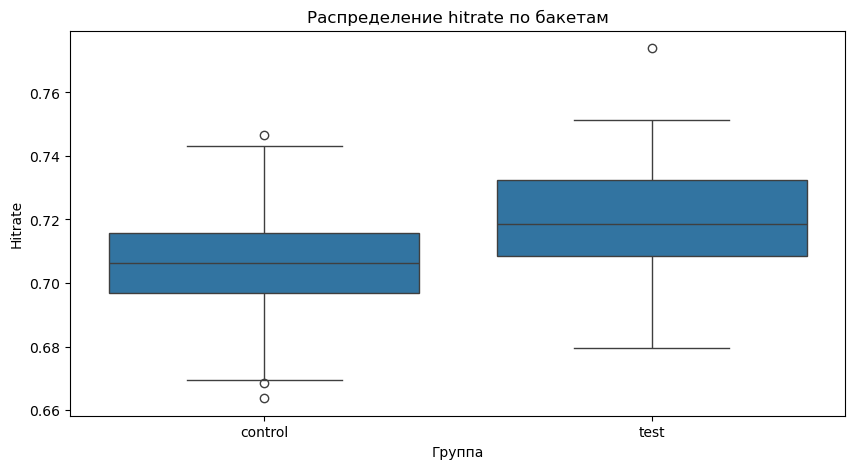

In [47]:
# 4. Визуализация распределений
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(data=bucket_stats, x="exp_group", y="hitrate")
plt.title("Распределение hitrate по бакетам")
plt.ylabel("Hitrate")
plt.xlabel("Группа")
plt.show()